In [1]:
import time
import numpy as np

import hoomd
import gsd.hoomd

from harmonic import HarmonicUpdater

#### initializing snapshot

In [2]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=9520)
sim.create_state_from_gsd(filename='./DATA/lattice.gsd')

#### initializing integrator

In [3]:
mc = hoomd.hpmc.integrate.Sphere(default_d=0.3, default_a=0.4)
mc.shape["A"] = dict(diameter=1.0)

#### harmonic constraint

In [4]:
lattice = gsd.hoomd.open('./DATA/lattice.gsd', 'rb')
pos = lattice[0].particles.position
ori = lattice[0].particles.orientation
box = lattice[0].configuration.box

k_init=30
k_second=20

k_rot_init=10
k_rot_second=0

t_ramp=int(1e5)
k_trans = hoomd.variant.Power(A=k_init, 
                              B=k_second,
                              power=1,
                              t_start=sim.timestep, 
                              t_ramp=t_ramp)
k_rot = hoomd.variant.Power(A=k_rot_init, 
                            B=k_rot_second,
                            power=1,
                            t_start=sim.timestep, 
                            t_ramp=t_ramp)



harmonic = hoomd.hpmc.external.field.Harmonic(reference_positions=pos,
                                              reference_orientations=ori,
                                              k_translational=k_trans,
                                              k_rotational=k_rot,
                                              symmetries=ori)
mc.external_potential=harmonic

#### harmonic updater

In [ ]:
harmonicupdater = hoomd.update.CustomUpdater(action=HarmonicUpdater(ref_pos=pos, 
                                                                    init_size=box[0]), trigger=1)

#### constant pressure updater

In [5]:
boxmc = hoomd.hpmc.update.BoxMC(trigger=hoomd.trigger.Periodic(10),
                                   betaP=8.0)

boxmc.volume['weight']=1.0
boxmc.volume['mode']='standard'
boxmc.volume['delta']=0.1

tune_boxmc = hoomd.hpmc.tune.BoxMCMoveSize.scale_solver(boxmc=boxmc,
                                                        trigger=hoomd.trigger.Periodic(100),
                                                        moves=['volume'],
                                                        target=0.2,
                                                        max_move_size={'volume':1})

#### logger for writing gsd

In [7]:
logger = hoomd.logging.Logger()
logger.add(mc, quantities=['type_shapes'])
logger.add(harmonicupdater, quantities=['rescale_factor', 'boxsize_t'])

gsd_writer = hoomd.write.GSD(filename='./DATA/trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(10),
                             mode='wb',
                             filter=hoomd.filter.All())
gsd_writer.log=logger

/Users/lina492375qw1188/opt/miniconda3/envs/alchemy/lib/python3.9/site-packages/hoomd/write/gsd.py:286: FutureWarning: log property is deprecated since v3.9.0. Use logger instead.
  warnings.warn(


#### attaching operations

In [8]:
sim.operations.writers.append(gsd_writer)
sim.operations.integrator = mc
sim.operations.updaters.append(harmonicupdater)
sim.operations.updaters.append(boxmc)
sim.operations.tuners.append(tune_boxmc)

#### run simulation

In [9]:
start = time.time()

sim.run(1e3)

print('Time elapsed', time.time()-start)

Time elapsed 2.814073085784912


#### Read trajectory

In [11]:
traj = gsd.hoomd.open('./DATA/trajectory.gsd', 'rb')

In [12]:
rescale_arr = []
boxsize_arr = []
for frame in traj:
    rescale_arr.append( frame.log['harmonic/HarmonicUpdater/rescale_factor'] )
    boxsize_arr.append( frame.log['harmonic/HarmonicUpdater/boxsize_t'] )
    
rescale_arr = np.array(rescale_arr)
boxsize_arr = np.array(boxsize_arr)

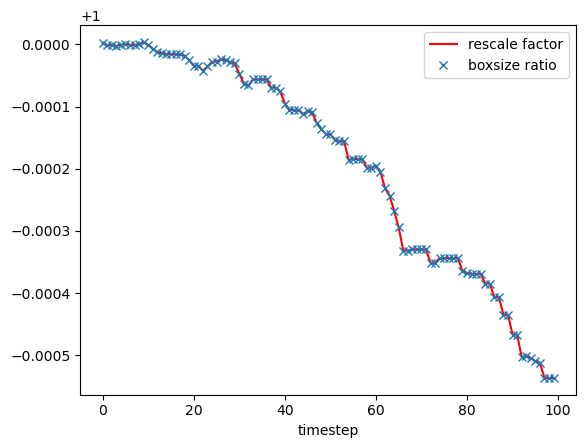

In [16]:
import matplotlib.pyplot as plt

plt.plot(rescale_arr, 'r-', label='rescale factor')
plt.plot(boxsize_arr/box[0], 'x', label='boxsize ratio')

plt.xlabel('timestep')
plt.legend()
plt.show()